In [1]:
import networkx as nx # make sure you installed networkx
import pandas as pd
import numpy as np

# Graph including only positive corsi influences
# Read in data
df = pd.read_csv("../../data/forwards/forwards_edgelist_corsi.csv")

# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'cf_inf_on2':'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', ['weight'],create_using=nx.DiGraph)

df = df.rename(columns={'weight':'notweight','cf_inf_on1':'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'playerId2', 'playerId1', edge_attr='weight',create_using=nx.DiGraph)

G = nx.compose(G0, G1)


# We are creating this graph specifically for community analysis, so we can clean up irrelevant nodes
# Delete edges with 0 or negative influence
edge_attrs = nx.get_edge_attributes(G, "weight")
for edge in edge_attrs.keys():
    if edge_attrs[edge] <= 0:
        G.remove_edge(edge[0], edge[1])

# Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))


# Copy a whole bunch of relevant stats to nodes for easier data analysis
# Add player names to nodes
players_df = pd.read_csv("../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)
player_names = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_name = players_df.loc[[player]]["playerName"].values[0]
    player_names[player] = player_name

nx.set_node_attributes(G, player_names, "playerName")

# on ice corsi
player_onIce_corsis = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_onIce_corsi = players_df.loc[[player]]["onIce_corsiPercentage"].values[0]
    player_onIce_corsis[player] = player_onIce_corsi

nx.set_node_attributes(G, player_onIce_corsis, "onIce_corsiPercentage")

# off ice corsi
player_offIce_corsis = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_offIce_corsi = players_df.loc[[player]]["offIce_corsiPercentage"].values[0]
    player_offIce_corsis[player] = player_offIce_corsi

nx.set_node_attributes(G, player_offIce_corsis, "offIce_corsiPercentage")

# on/off ice corsi diff
player_corsi_diffs = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_corsi_diff = players_df.loc[[player]]["on_off_corsi_diff"].values[0]
    player_corsi_diffs[player] = player_corsi_diff

nx.set_node_attributes(G, player_corsi_diffs, "on_off_corsi_diff")

# on ice goals for per 60
player_gf_per60s = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_gf_per60 = players_df.loc[[player]]["OnIce_F_goals_per60"].values[0]
    player_gf_per60s[player] = player_gf_per60

nx.set_node_attributes(G, player_gf_per60s, "onIce_F_goals_per60")

# d zone giveaways per 60
players_dz_giveaways = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_dz_giveaways = players_df.loc[[player]]["I_F_dZoneGiveaways_per60"].values[0]
    players_dz_giveaways[player] = player_dz_giveaways

nx.set_node_attributes(G, players_dz_giveaways, "I_F_dZoneGiveaways_per60")

# average icetime
players_avg_TOI_dict = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_avg_TOI = players_df.loc[[player]]["average_TOI"].values[0]
    players_avg_TOI_dict[player] = player_avg_TOI

nx.set_node_attributes(G, players_avg_TOI_dict, "average_TOI")

# NOTE: this uses data calculated in defense-overall.ipynb
# average corsi influence
players_avg_TOI_dict = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_avg_TOI = players_df.loc[[player]]["average_corsi_influence"].values[0]
    players_avg_TOI_dict[player] = player_avg_TOI

nx.set_node_attributes(G, players_avg_TOI_dict, "average_corsi_influence")


In [2]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)

Number of nodes:  758
Number of edges:  4442


In [3]:
# Run community detection algorithms, add info to graph and export to gephi for visualization
import networkx.algorithms.community as nxc

# Greedy Modularity
greedy_communities = nxc.greedy_modularity_communities(G, weight='weight')

# add community info to node attributes
i = 0
greedy_communities_dict = dict.fromkeys(G.nodes)
for community in greedy_communities:
    for player in community:
        greedy_communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, greedy_communities_dict, "greedy_community")

# output a gephi file for ez visualization
nx.write_gexf(G, 'defense-positive.gexf')

20


In [10]:
# Display stat distributions and other relevant stuff to identify trends within and between communities
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

players_df = pd.read_csv("../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)

# Remove players with less than 10 games to clean up playerbase data a bit
players_df = players_df.drop(players_df[players_df.games_played < 10].index)

In [20]:
def plot_distributions(stat):
    # Plot corsi influence distribution of entire playerbase
    playerbase_stats = players_df[stat].values
    print(np.nanmean(playerbase_stats))
    print(np.nanstd(playerbase_stats))
    n, bins, patches = plt.hist(playerbase_stats, 30)
    plt.xlabel(stat)
    plt.ylabel("Count")
    plt.title("Overall Playerbase " + stat)
    plt.show()

    # Plot corsi distribution of each community individually
    graph_stats = dict(G.nodes(data=stat, default=1))
    i = 0
    for community in greedy_communities:
        players_stats = []
        for player in community:
            players_stats.append(players_df.loc[player][stat])
        print(np.mean(players_stats))
        print(np.std(players_stats))
        plt.hist(players_stats, bins)
        plt.xlabel(stat)
        plt.ylabel("Count")
        title = "Community: " + str(i)
        plt.title(title)
        plt.show()
        i += 1

-0.013114989599236201
0.03709830372243571


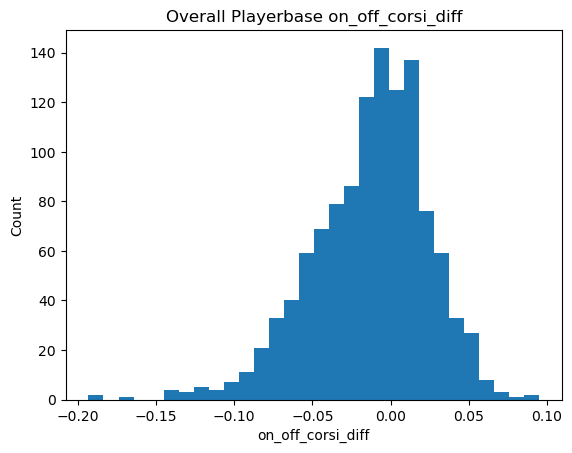

-0.00639270659907707
0.026181306711473982


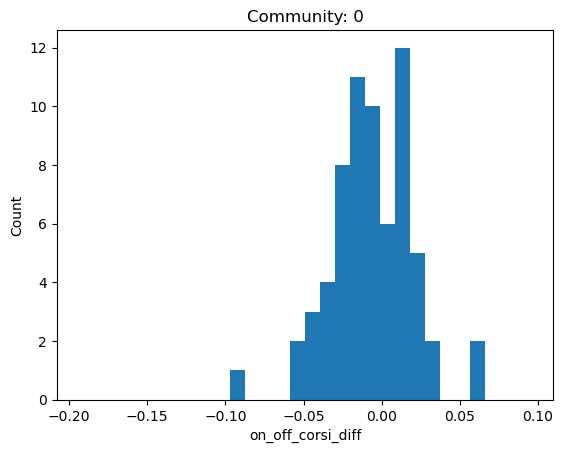

-1.6505975194614647e-06
0.02385806946075048


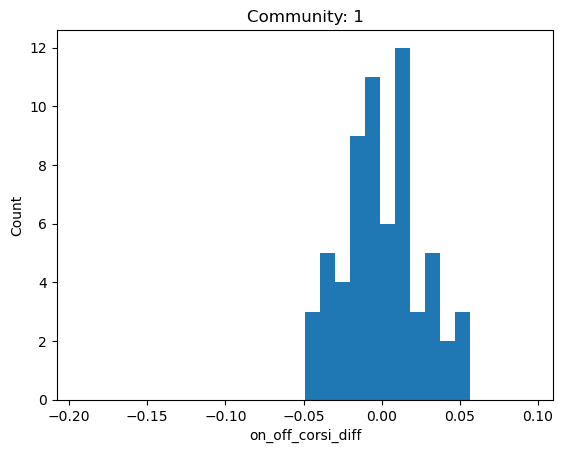

-0.00485657623013308
0.02731793203345719


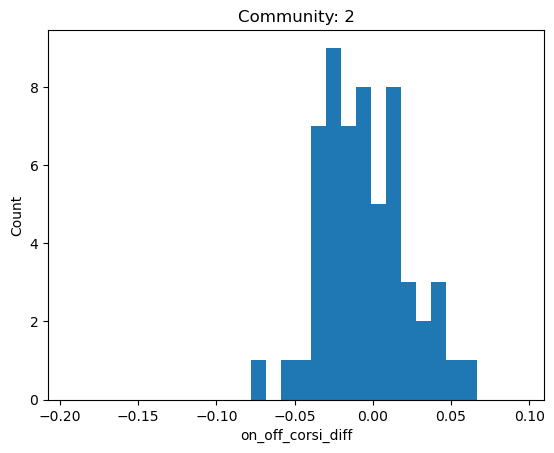

-0.006581865088981972
0.02465480570024458


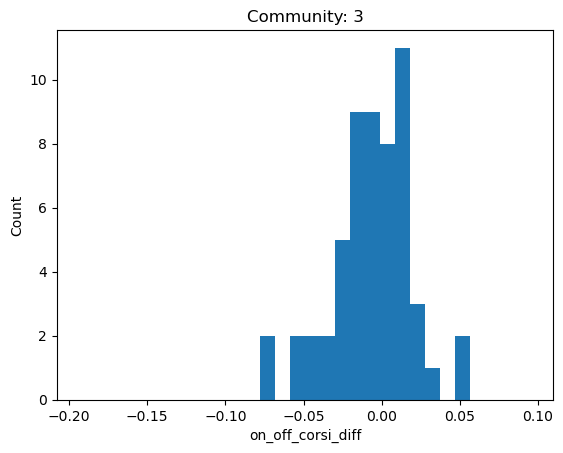

0.001001594768670004
0.033663418280200315


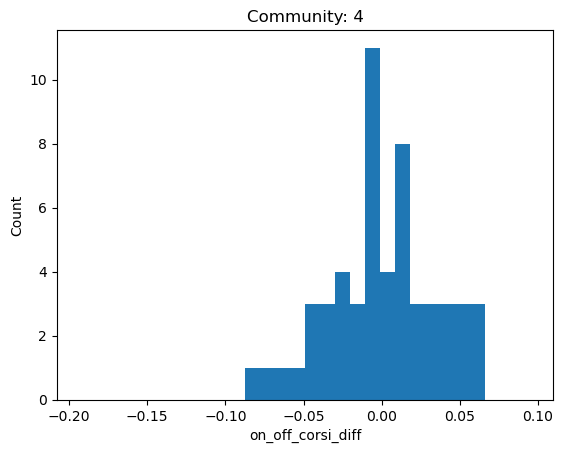

-0.003919073018406243
0.028990296105987492


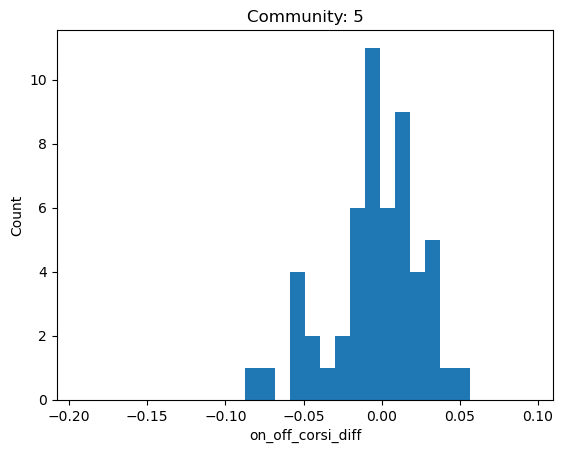

-0.008394343479507377
0.0320261037238274


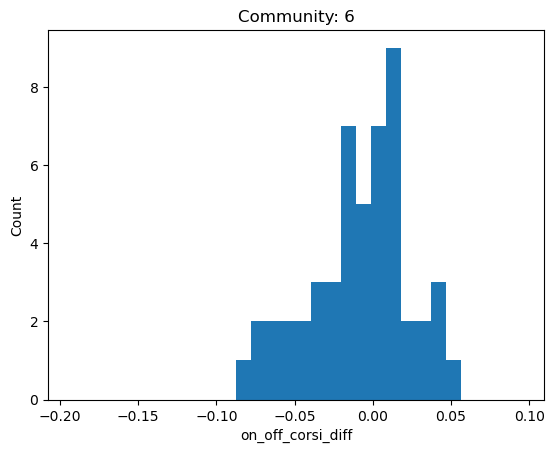

-0.00918035458917244
0.03451694908284759


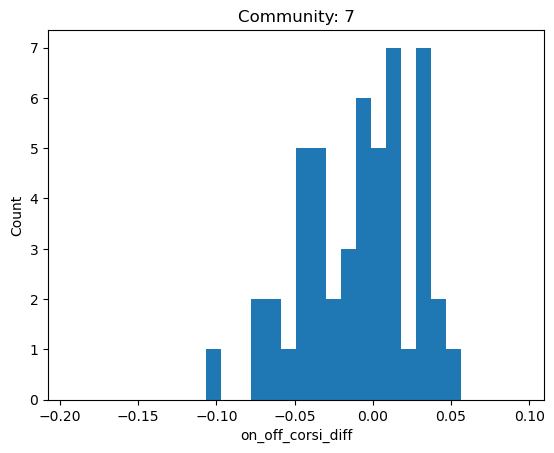

-0.010355107929096184
0.02804279785377025


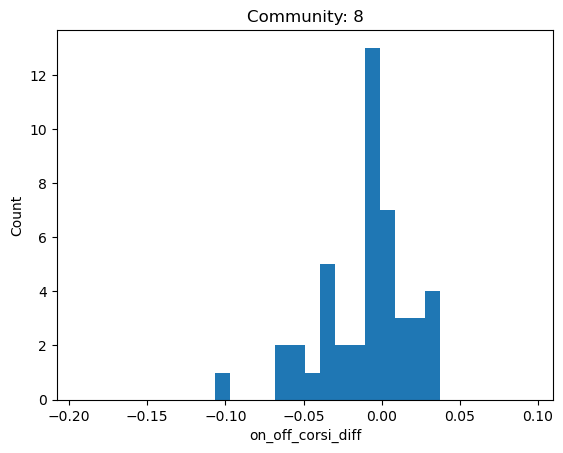

0.00046005594843516516
0.03052152008576613


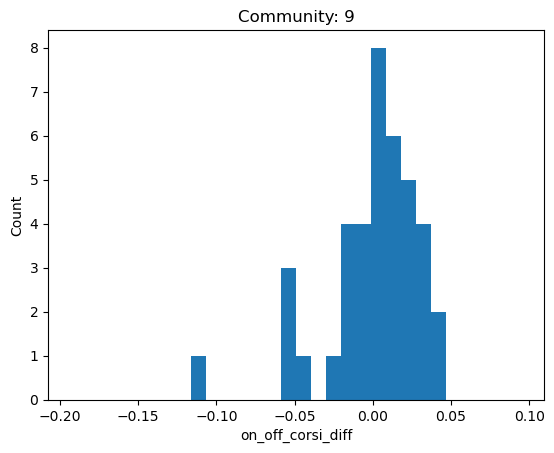

0.008599599125890086
0.028604861029114168


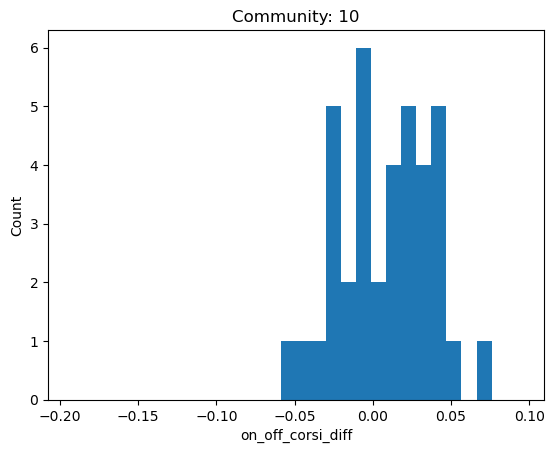

-0.009208442650766145
0.04088674312319197


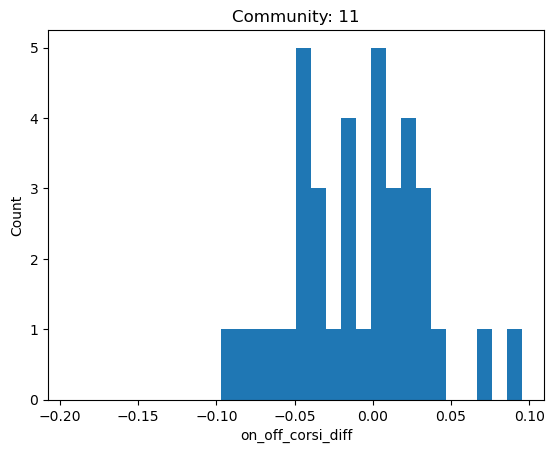

-0.006506949172908128
0.03148888360461093


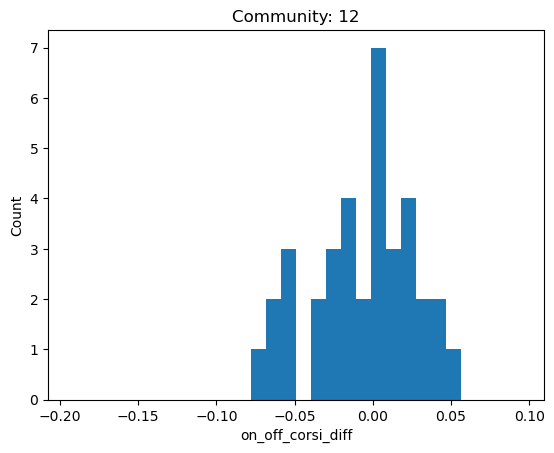

0.004447173442027239
0.025962575272471818


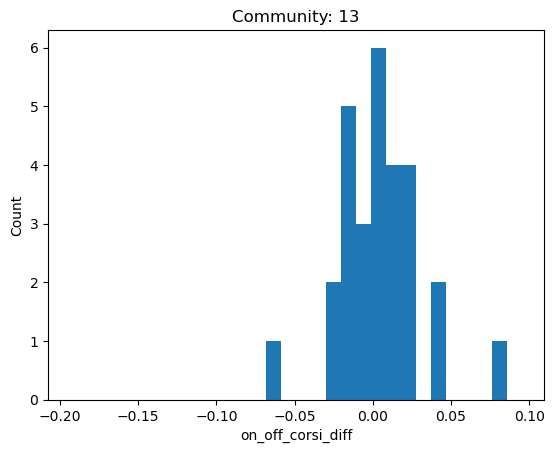

-0.01476795164999198
0.025878399376269044


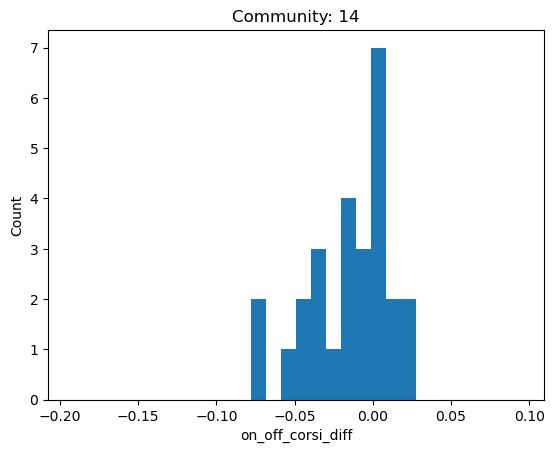

0.004920287804068038
0.02873908447835


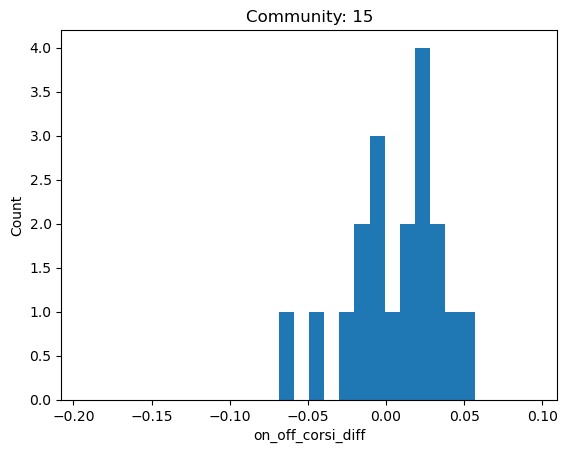

-0.012746354648314182
0.03302126142091337


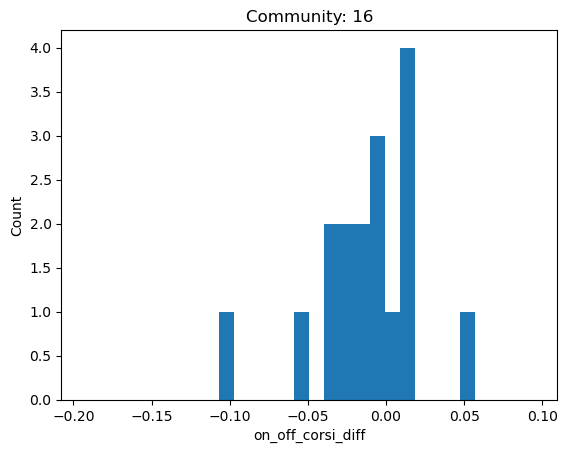

-0.014271776069694276
0.027913066064241498


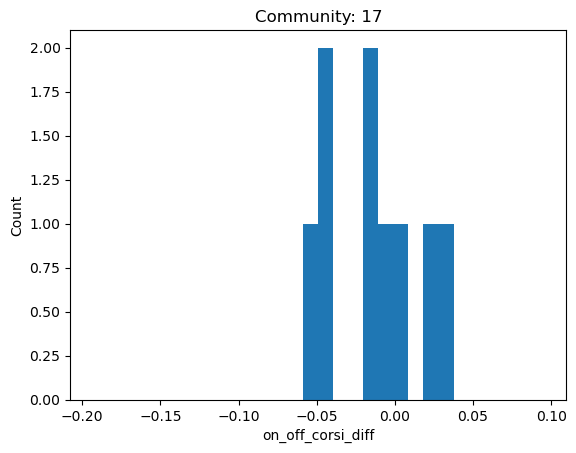

-0.032062723569338925
0.02521358738669731


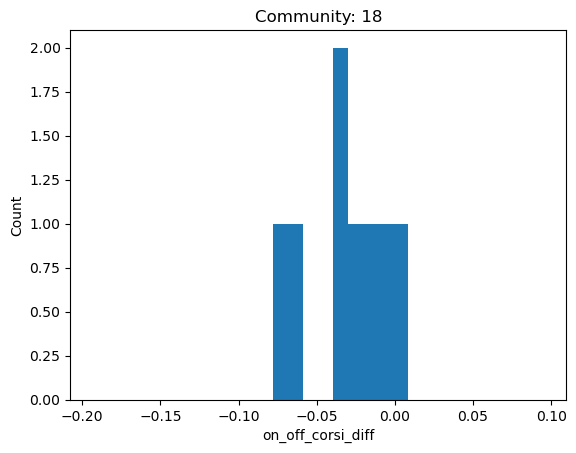

0.008448340435512666
0.02004539642960601


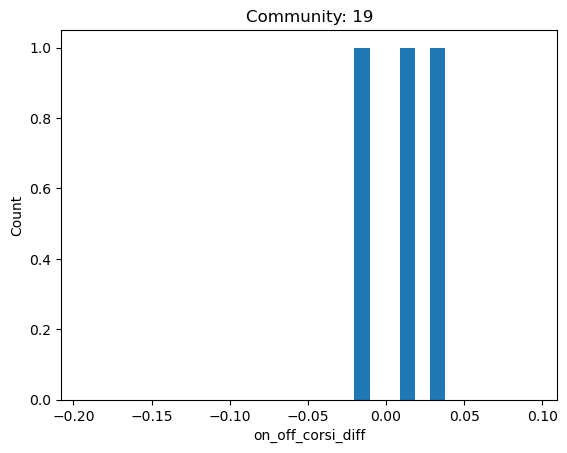

In [26]:
# Plot corsi influence distribution of entire playerbase
plot_distributions("on_off_corsi_diff")
